In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tf = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dl = DataLoader(
    datasets.ImageFolder('Training/', tf),
    batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)

test_dl = DataLoader(
    datasets.ImageFolder('Testing/', tf),
    batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(128 * 3 * 3, 256), nn.ReLU(), nn.Dropout(0.2), 
    nn.Linear(256, 4) 
).to(device)

In [ ]:
from torch import optim

opt = optim.AdamW(model.parameters(), 1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model.train()

for epoch in range(25):
    running_loss = 0.0
    for x, y in train_dl:
        opt.zero_grad()
        
        loss = loss_fn(model(x.to(device)), y.to(device))
        loss.backward()
        
        running_loss += loss.item()
        opt.step()
    print(f"Epoch {epoch+1} - Loss: {running_loss}")
    

In [15]:
model.eval()
test_loss, correct = 0.0, 0

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        test_loss += loss_fn(logits, y).item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        
test_loss /= len(test_dl.dataset)
accuracy = correct / len(test_dl.dataset)
print(f"Test Loss: {test_loss}, Accuracy: {accuracy*100:.2f}%")
        

c:\Users\Abdullah\neuralnine\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Loss: 0.32019040754603395, Accuracy: 87.80%


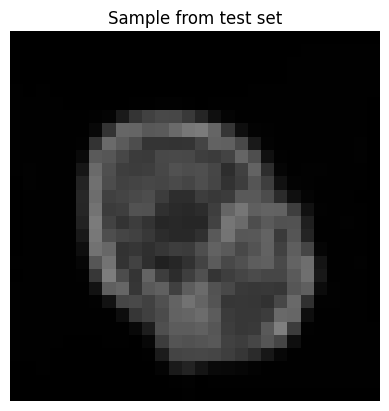

Predicted: glioma, Actual: glioma


In [16]:
import random

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model.eval()

idx = random.randrange(len(test_dl.dataset))
img, label = test_dl.dataset[idx]

unnorm = img * 0.5 + 0.5
plt.imshow(to_pil_image(unnorm))
plt.axis('off')
plt.title('Sample from test set')
plt.show()

with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    pred = logits.argmax(dim=1).item()
    
class_names = test_dl.dataset.classes
print(f"Predicted: {class_names[pred]}, Actual: {class_names[label]}")